We will now import all the libraries needed for training process. It will use Tensorflow backend and keras at frontend.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random
import warnings
warnings.filterwarnings("ignore")

Using head, we will show the first five values for the CSV on the desired format.

In [ ]:
columns = ["center", "left", "right", "steering", "throttle", "reverse", "speed"]
data = pd.read_csv("/content/drive/MyDrive/Backup/Colab Notebooks/SelfDrivingCarSimulator/self_driving_car_dataset_jungle/driving_log.csv", names=columns)
pd.set_option("display.max_colwidth", -1)
data.head()

center  \
0  C:\Users\Andy\Desktop\self_driving_car_dataset_jungle\IMG\center_2022_04_10_12_44_27_913.jpg   
1  C:\Users\Andy\Desktop\self_driving_car_dataset_jungle\IMG\center_2022_04_10_12_44_27_983.jpg   
2  C:\Users\Andy\Desktop\self_driving_car_dataset_jungle\IMG\center_2022_04_10_12_44_28_052.jpg   
3  C:\Users\Andy\Desktop\self_driving_car_dataset_jungle\IMG\center_2022_04_10_12_44_28_121.jpg   
4  C:\Users\Andy\Desktop\self_driving_car_dataset_jungle\IMG\center_2022_04_10_12_44_28_191.jpg   

                                                                                         left  \
0  C:\Users\Andy\Desktop\self_driving_car_dataset_jungle\IMG\left_2022_04_10_12_44_27_913.jpg   
1  C:\Users\Andy\Desktop\self_driving_car_dataset_jungle\IMG\left_2022_04_10_12_44_27_983.jpg   
2  C:\Users\Andy\Desktop\self_driving_car_dataset_jungle\IMG\left_2022_04_10_12_44_28_052.jpg   
3  C:\Users\Andy\Desktop\self_driving_car_dataset_jungle\IMG\left_2022_04_10_12_44_28_121.jpg   
4  C:\Users\Andy\Desktop\self_driving_car_dataset_jungle\IMG\left_2022_04_10_12_44_28_191.jpg   

                                                                                         right  \
0  C:\Users\Andy\Desktop\self_driving_car_dataset_jungle\IMG\right_2022_04_10_12_44_27_913.jpg   
1  C:\Users\Andy\Desktop\self_driving_car_dataset_jungle\IMG\right_2022_04_10_12_44_27_983.jpg   
2  C:\Users\Andy\Desktop\self_driving_car_dataset_jungle\IMG\right_2022_04_10_12_44_28_052.jpg   
3  C:\Users\Andy\Desktop\self_driving_car_dataset_jungle\IMG\right_2022_04_10_12_44_28_121.jpg   
4  C:\Users\Andy\Desktop\self_driving_car_dataset_jungle\IMG\right_2022_04_10_12_44_28_191.jpg   

   steering  throttle  reverse     speed  
0  0.00      1.0       0        21.69488  
1  0.00      1.0       0        22.50011  
2  0.00      1.0       0        23.11461  
3  0.00      1.0       0        23.89061  
4  0.05      1.0       0        24.46815

As this is picking up the entire path from the local machine, we need to use ntpath function to get the network path assigned. We will declare a name path_leaf and assign accordingly.

In [ ]:
def pathleaf(path):
    head, tail = ntpath.split(path)
    return tail

data["center"] = data["center"].apply(pathleaf)
data["left"] = data["left"].apply(pathleaf)
data["right"] = data["right"].apply(pathleaf)
data.head()

center                              left  \
0  center_2022_04_10_12_44_27_913.jpg  left_2022_04_10_12_44_27_913.jpg   
1  center_2022_04_10_12_44_27_983.jpg  left_2022_04_10_12_44_27_983.jpg   
2  center_2022_04_10_12_44_28_052.jpg  left_2022_04_10_12_44_28_052.jpg   
3  center_2022_04_10_12_44_28_121.jpg  left_2022_04_10_12_44_28_121.jpg   
4  center_2022_04_10_12_44_28_191.jpg  left_2022_04_10_12_44_28_191.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2022_04_10_12_44_27_913.jpg  0.00      1.0       0        21.69488  
1  right_2022_04_10_12_44_27_983.jpg  0.00      1.0       0        22.50011  
2  right_2022_04_10_12_44_28_052.jpg  0.00      1.0       0        23.11461  
3  right_2022_04_10_12_44_28_121.jpg  0.00      1.0       0        23.89061  
4  right_2022_04_10_12_44_28_191.jpg  0.05      1.0       0        24.46815

We will bin the number of values where the number will be equal to 25 (odd number aimed to get center distribution). We will see the histogram using the np.histogram option on data frame ‘steering’, we will divide it to the number of bins. We keep samples at 400 and then we draw a line. We see the data is centered along the middle that is 0.

In [ ]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data["steering"], num_bins)
print(bins)

[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]


Plot on it

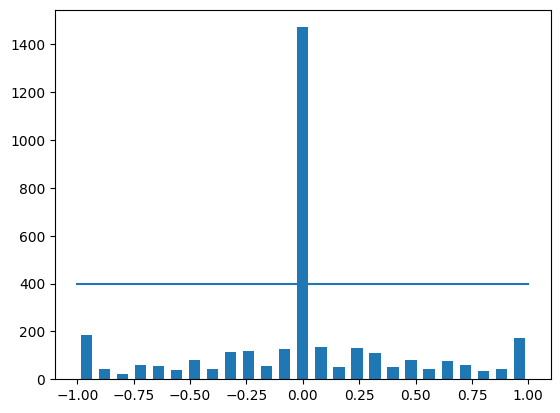

In [ ]:
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot(
    (np.min(data["steering"]), np.max(data["steering"])),
    (samples_per_bin, samples_per_bin),
)


In [ ]:
print("Total Data:", len(data))

Total Data: 3404


We wil specify a variable rove_list.We will specify samples we want to remove using looping construct through every single bin we will iterate through all the steering data. We will shuffle the data and romve some from it as it is now uniformly structured after shuffling.The output will be the distribution of steering angle that are much more uniform. There are significant amount of left steering angle and right steering angle eliminating the bias to drive straight all the time.

In [ ]:
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data["steering"])):
        if data["steering"][i] >= bins[j] and data["steering"][i] <= bins[j + 1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)
print("Removed:", len(remove_list))

Removed: 1072


In [ ]:
data.drop(data.index[remove_list], inplace=True)

In [ ]:
print("Remaining:", len(data))

Remaining: 2332


Plot on it

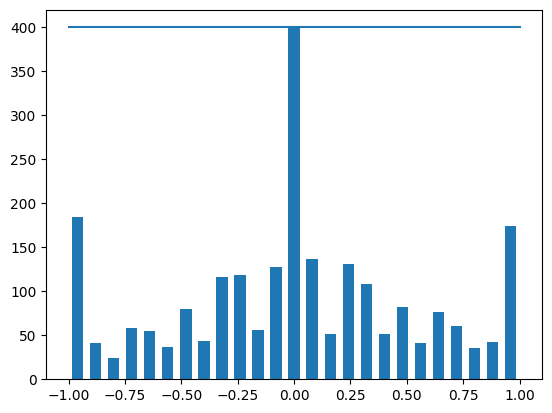

In [ ]:
hist, _ = np.histogram(data["steering"], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot(
    (np.min(data["steering"]), np.max(data["steering"])),
    (samples_per_bin, samples_per_bin),
)

In [ ]:
print(data.iloc[1])

center      center_2022_04_10_12_44_28_262.jpg
left        left_2022_04_10_12_44_28_262.jpg  
right       right_2022_04_10_12_44_28_262.jpg 
steering    0.25                              
throttle    1.0                               
reverse     0                                 
speed       25.20827                          
Name: 5, dtype: object


We will now load the image into array to manipulate them accordingly. We will define a function named locd_img_steering. We will have image path as empty list and steering as empty list and then loop through. We use iloc selector as data frame based on the specific index we will use cut data for now.

In [ ]:
def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
        image_path.append(os.path.join(datadir, left.strip()))
        steering.append(float(indexed_data[3]) + 0.15)
        image_path.append(os.path.join(datadir, right.strip()))
        steering.append(float(indexed_data[3]) - 0.15)
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings

We will be splitting the image path as well as storing arrays accordingly.

In [ ]:
image_paths, steerings = load_img_steering("/content/drive/MyDrive/Backup/Colab Notebooks/SelfDrivingCarSimulator/self_driving_car_dataset_jungle/IMG", data)
X_train, X_valid, y_train, y_valid = train_test_split(
    image_paths, steerings, test_size=0.2, random_state=6
)
print("Training Samples: {}\nValid Samples: {}".format(len(X_train), len(X_valid)))


Training Samples: 5596
Valid Samples: 1400


We will have the histograms now.

Text(0.5, 1.0, 'Validation set')

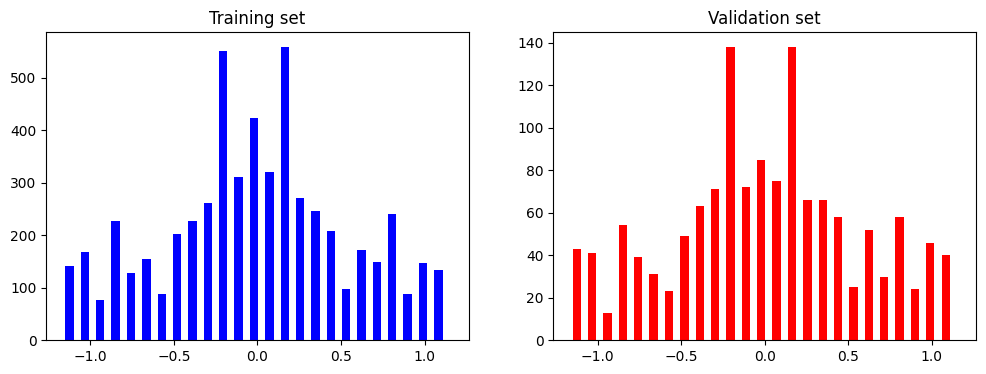

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color="blue")
axes[0].set_title("Training set")
axes[1].hist(y_valid, bins=num_bins, width=0.05, color="red")
axes[1].set_title("Validation set")

In the next steps, we normalize the data and in the nvdia model, we will have to keep it in a UAV pattern as well as slice unnecessary information. We preprocess the image too.

Zoom.The images in the dataset have relevant features in the lower part where the road is visible. The external environment above a certain image portion will never be used to determine the output and thus can be cropped. Approximately, 30% of the top portion of the image is cut and passed in the training set. The snippet of code and transformation of an image after cropping and resizing it to original image can be seen in below.

Text(0.5, 1.0, 'Zoomed Image')

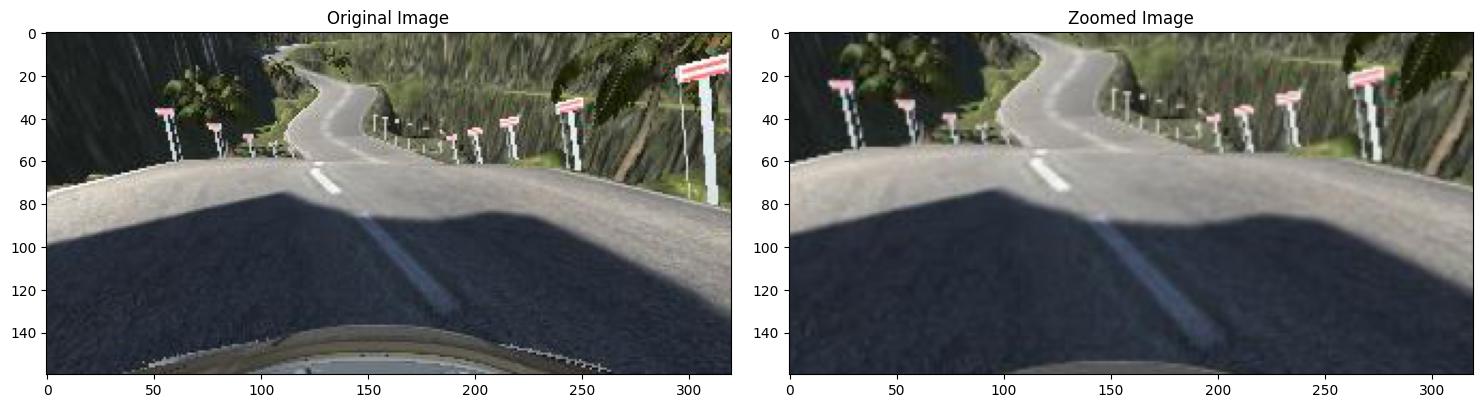

In [ ]:
def zoom(image):
    zoom = iaa.Affine(scale=(1, 1.3))
    image = zoom.augment_image(image)
    return image


image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title("Original Image")

axs[1].imshow(zoomed_image)
axs[1].set_title("Zoomed Image")

Shift(horizontal/vertical).The image is shifted by a small amount, it is vertical shift and horizontal shift as below.

Text(0.5, 1.0, 'Panned Image')

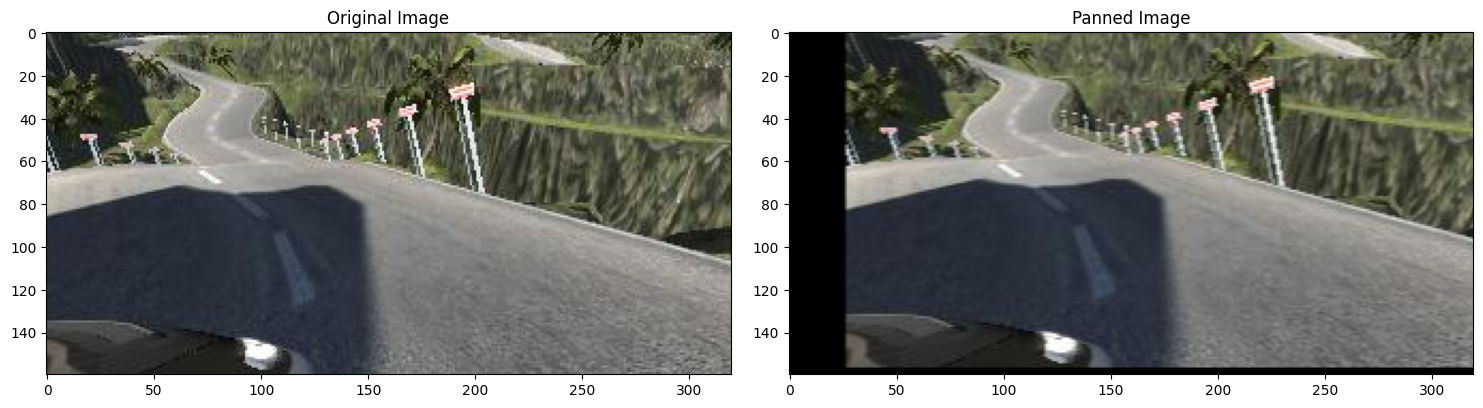

In [ ]:
def pan(image):
    pan = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image


image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title("Original Image")

axs[1].imshow(panned_image)
axs[1].set_title("Panned Image")

Brightness.To generalize to the weather conditions with bright sunny day or cloudy, lowlight conditions, the brightness augmentation can prove to be very useful. The code snippet and increase of brightness can be seen below. Similarly, I have randomly also lowered down the level of brightness for other conditions.

Text(0.5, 1.0, 'Brightness altered image ')

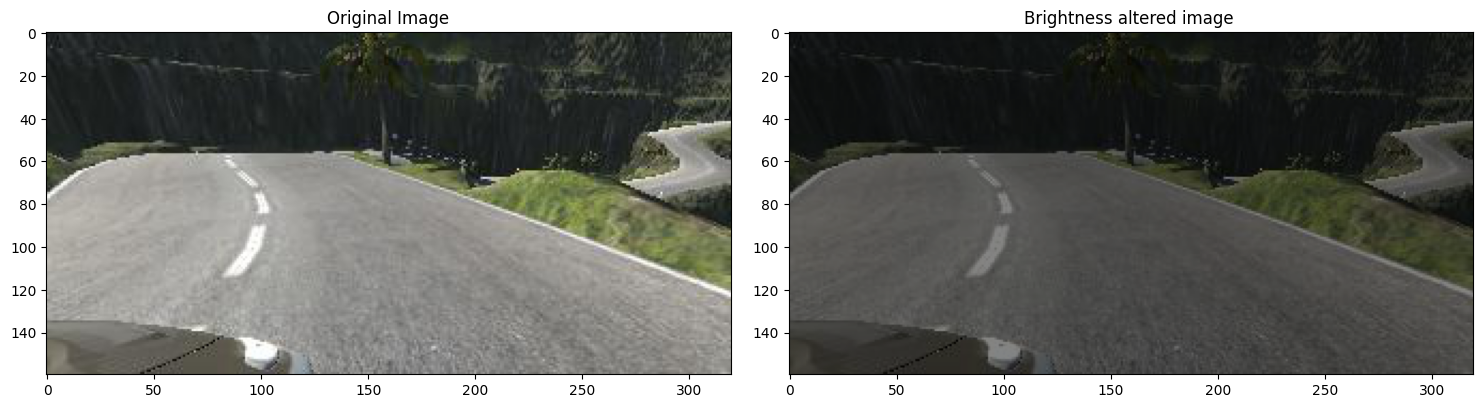

In [ ]:
def random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image


image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title("Original Image")

axs[1].imshow(brightness_altered_image)
axs[1].set_title("Brightness altered image ")

Flip(horizontal).The image is flipped horizontally (i.e. a mirror image of the original image is passed to the dataset). The motive behind this is that the model gets trained for similar kinds of turns on opposite sides too. This is important because Track 1 includes only left turns. The snippet of code and transformation of an image after flipping it can be seen in below.

Text(0.5, 1.0, 'Flipped Image - Steering Angle:0.4')

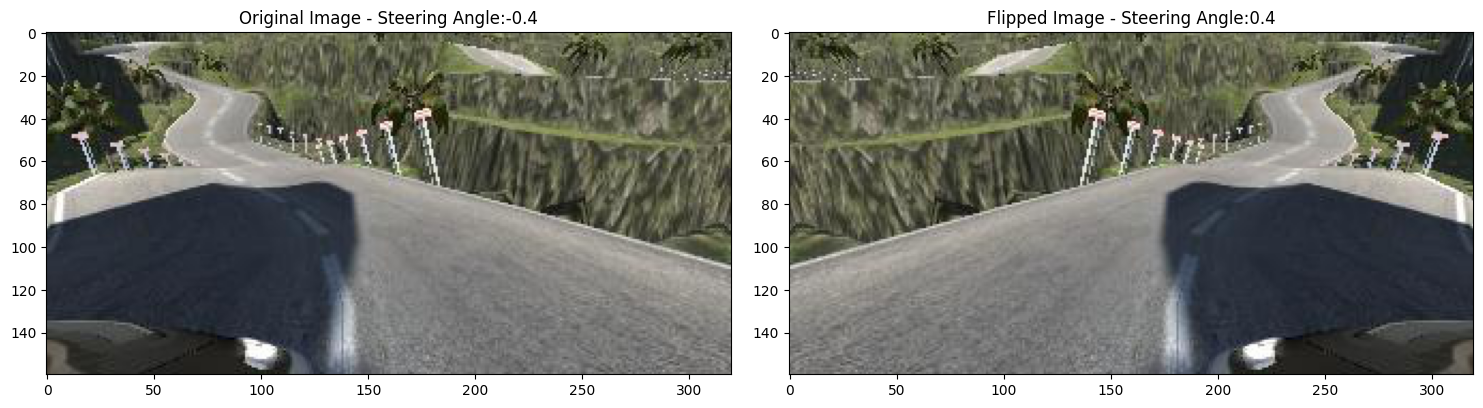

In [ ]:
def random_flip(image, steering_angle):
    image = cv2.flip(image, 1)
    steering_angle = -steering_angle
    return image, steering_angle


random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]

original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title("Original Image - " + "Steering Angle:" + str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title("Flipped Image - " + "Steering Angle:" + str(flipped_steering_angle))

To have a look what we have at this moment

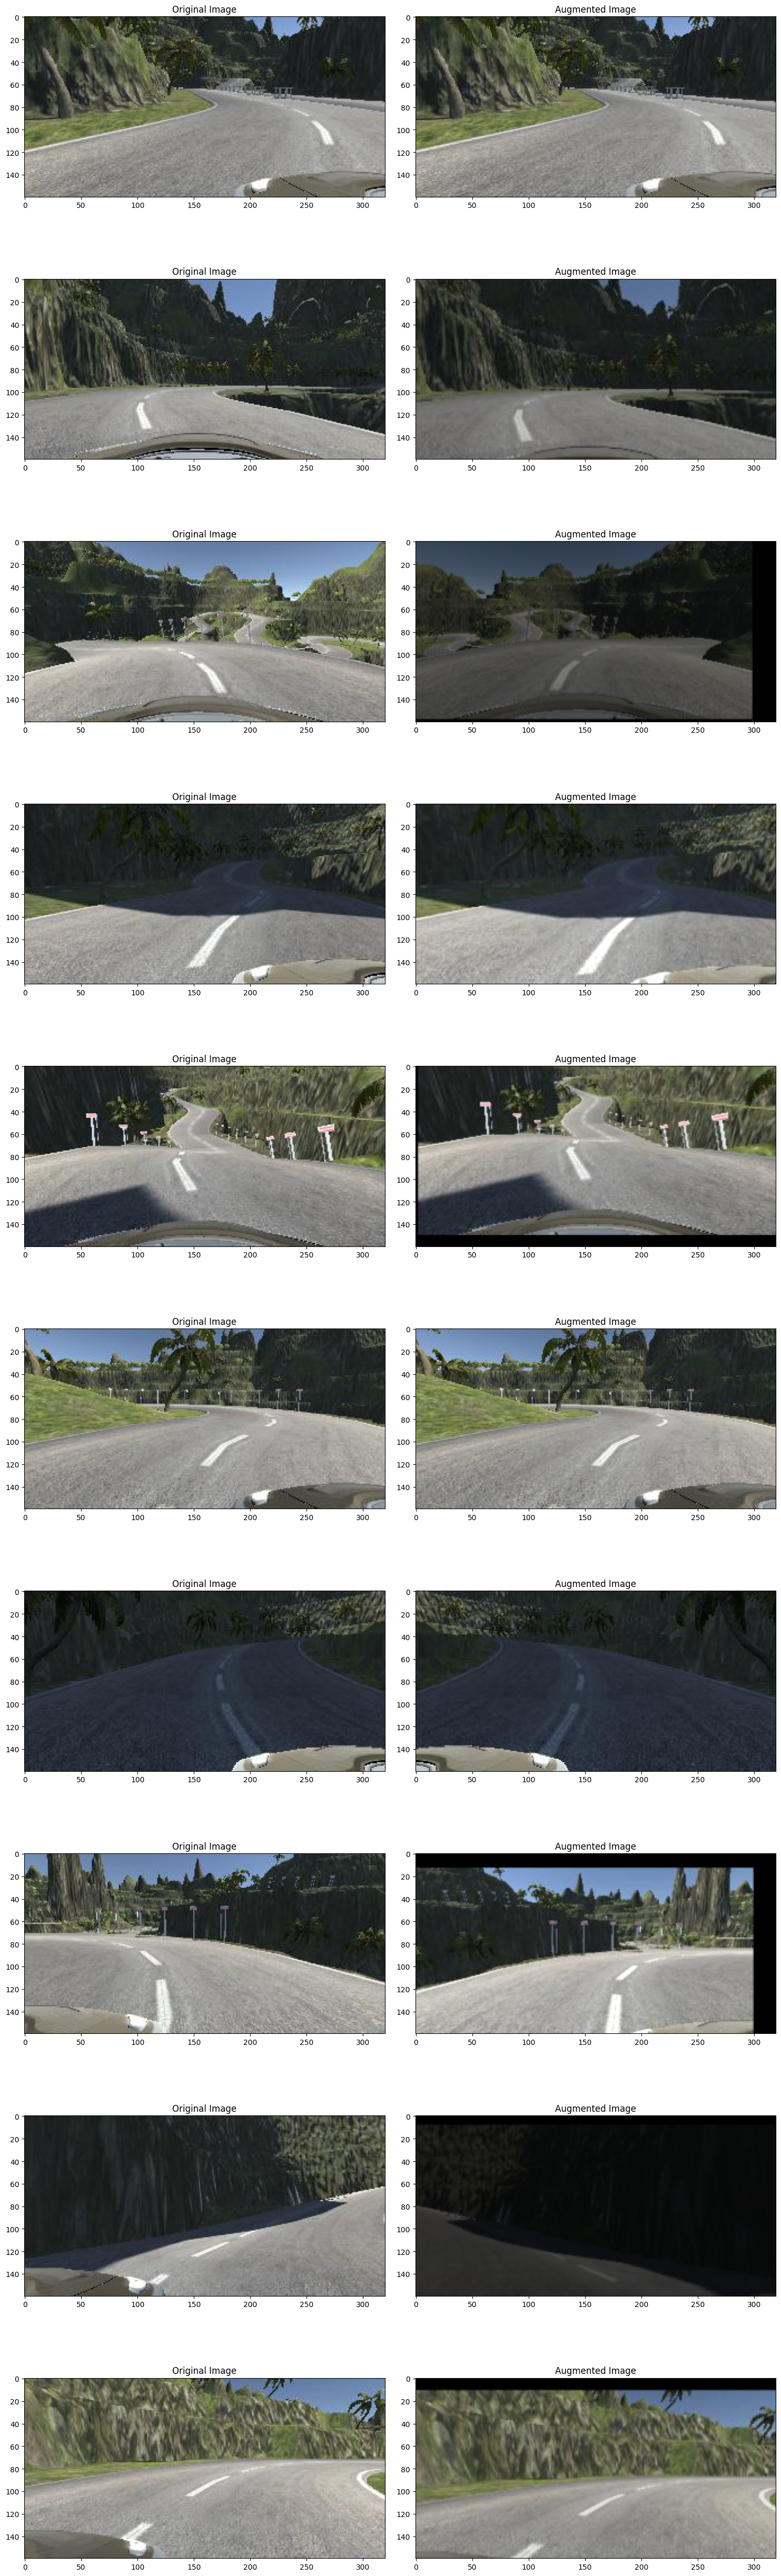

In [ ]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = random_brightness(image)
    if np.random.rand() < 0.5:
        image, steering_angle = random_flip(image, steering_angle)
    return image, steering_angle


ncol = 2
nrow = 10

fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
    randnum = random.randint(0, len(image_paths) - 1)
    random_image = image_paths[randnum]
    random_steering = steerings[randnum]

    original_image = mpimg.imread(random_image)
    augmented_image, steering = random_augment(random_image, random_steering)

    axs[i][0].imshow(original_image)
    axs[i][0].set_title("Original Image")

    axs[i][1].imshow(augmented_image)
    axs[i][1].set_title("Augmented Image")